# RSI efficiency on Warsaw Stock Exchange based on WIG20

In [1]:
""" append parent dir to sys.path for local imports """
import sys
if '..\\' not in sys.path: sys.path.append('..\\')   

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
from stocks.stock import Stock
from stocks.stock_index import wig20
from analysis.rsi import rsi, rsi_cross_signals
sns.set()

## Time range of interest

In [2]:
start_date = '2019-01-01'
end_date = '2019-12-31'

time_range = pd.date_range(start_date, end_date)

## Get OHLC information, and calculate RSI and signals

In [3]:
stock_data = pd.DataFrame(columns=['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'Buy', 'Sell'])
stock_data

,Date,Ticker,Open,High,Low,Close,Volume,RSI,Buy,Sell


In [4]:
stock_data = pd.DataFrame(columns=['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'Buy', 'Sell'])

for ticker in wig20:
    """ create Stock instance """
    ticker_stock = Stock(ticker)
    
    """ get prices from given time range """
    map_ = ticker_stock.ohlc.index.isin(time_range)
    ticker_data = ticker_stock.ohlc[map_]
    
    """ calculate RSI using all available data """
    ticker_data = ticker_data.join(rsi(ticker_stock.ohlc))
    
    """ find Buy and Sell signals """
    ticker_data['Buy'] = rsi_cross_signals(ticker_data, 30, 'onrise')
    ticker_data['Sell'] = rsi_cross_signals(ticker_data, 70, 'onrise')
    
    """ insert date and ticker """
    ticker_data.insert(0, 'Ticker', ticker)
    ticker_data.insert(0, 'Date', ticker_data.index)
    
    """ collect data in one table """
    stock_data = stock_data.append(ticker_data, ignore_index=True)
    
stock_data

,Date,Ticker,Open,High,Low,Close,Volume,RSI,Buy,Sell
0,2019-01-02,ALR,53.150,55.150,52.900,55.000,187429.0,50.219851,False,False
1,2019-01-03,ALR,55.000,55.000,53.300,53.400,219807.0,45.128856,False,False
2,2019-01-04,ALR,53.900,55.000,53.900,54.750,127074.0,49.756946,False,False
3,2019-01-07,ALR,55.050,56.200,54.800,56.200,187654.0,54.223000,False,False
4,2019-01-08,ALR,55.650,56.200,54.900,55.950,168800.0,53.342603,False,False
...,...,...,...,...,...,...,...,...,...,...
4955,2019-12-19,TPE,1.655,1.671,1.625,1.630,3589331.0,43.609097,False,False
4956,2019-12-20,TPE,1.618,1.654,1.601,1.601,7055418.0,41.382488,False,False
4957,2019-12-23,TPE,1.600,1.629,1.581,1.586,4872952.0,40.238078,False,False
4958,2019-12-27,TPE,1.600,1.652,1.600,1.641,2459368.0,46.121585,False,False


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B0790DD9A0>,
      dtype=object)

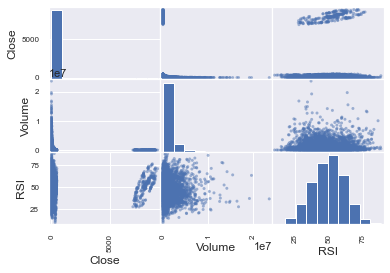

In [5]:
pd.plotting.scatter_matrix(stock_data[['Close', 'Volume', 'RSI']])

## Extract close price changes after buy signal

In [6]:
price_change = pd.DataFrame()
  
for data in stock_data.values():
    buy_map = data['Buy']
    
    """ for each buy signal """
    for buy in data[buy_map].index:
        
        """ get close price on the day of the signal and 30 following days (31 days together) """
        price_after_buy_signal = data.loc[buy:].head(31)['Close']
        
        """ reset index and transpose to a row """
        price_after_buy_signal = price_after_buy_signal.reset_index().drop(['Date'], axis=1)
        price_after_buy_signal = price_after_buy_signal.transpose()
        
        """ collect all in one DataFrame """
        price_change = price_change.append(price_after_buy_signal, ignore_index=True)

TypeError: 'numpy.ndarray' object is not callable

## Calculate relative price change

In [ ]:
""" calculate price change relative to the price on the day of the signal """
price_change_relative = price_change.div(price_change.loc[:,0], axis=0)
price_change_relative

In [ ]:
price_change_relative.transpose().plot(legend=False)

In [ ]:
price_change_relative.mean(axis=0).plot(legend=False)